In [2]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler, StringIndexer
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import when, col, expr
from sklearn.ensemble import IsolationForest
import numpy as np

In [19]:
spark = SparkSession.builder \
    .appName("course_work_anomay_detection") \
    .master("local[*]") \
    .config('spark.executor.memory', '20g') \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [13]:
spark.stop()

In [20]:
file_path = "file:///opt/spark/data/creditcard.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

data.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [5]:
fraud_df = data.where(col("Class") == 1)
fraud_count = fraud_df.where(col("Class") == 1).count()

non_fraud_df = data.where(col("Class") == 0)

non_fraud_count = non_fraud_df.count()
n_samples_to_add = non_fraud_count - fraud_count

print(n_samples_to_add/ fraud_count)

# Randomly sample the fraud transactions to add duplicates
fraud_oversampled_df = fraud_df.sample(withReplacement=True, fraction=n_samples_to_add/fraud_count, seed=3345)
# Combine the oversampled fraud data with the non-fraud data
balanced_df = non_fraud_df.union(fraud_oversampled_df)

# Show the new counts for validation
balanced_fraud_count = balanced_df.filter(balanced_df['Class'] == 1).count()
balanced_non_fraud_count = balanced_df.filter(balanced_df['Class'] == 0).count()

print(f"Balanced Fraud transactions: {balanced_fraud_count}")
print(f"Balanced Non-fraud transactions: {balanced_non_fraud_count}")

576.8760162601626
Balanced Fraud transactions: 284563
Balanced Non-fraud transactions: 284315


Використаємо K-means для кластеризації даних. І пошуку аномалій.


In [85]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf, col, when
from pyspark.sql.types import DoubleType

# Assemble the features
print(balanced_df.columns)
assembler = VectorAssembler(inputCols=data.columns[:-1], outputCol="features")
assembled_data = assembler.transform(data)

# Define a function to calculate distances to centroids
def distance_to_centroid(features, centroid):
    return float(features.squared_distance(centroid))

distance_udf = udf(distance_to_centroid, DoubleType())

# Fit a KMeans model
kmeans = KMeans(k=2, seed=3345)
model = kmeans.fit(assembled_data)

# Get the centroids
centroids = model.clusterCenters()

# Define a function to calculate the distance to the nearest centroid
def distance_to_nearest_centroid(features, centroids):
    return float(min([features.squared_distance(centroid) for centroid in centroids]))

distance_udf = udf(lambda features: distance_to_nearest_centroid(features, centroids), DoubleType())

# Calculate the distance to the nearest centroid
data_with_distances = model.transform(assembled_data)
data_with_distances = data_with_distances.withColumn("distance_to_nearest_centroid", distance_udf(col("features")))
data_with_distances.show(5)

# Calculate the threshold for anomaly detection
threshold = data_with_distances.approxQuantile("distance_to_nearest_centroid", [0.99], 0.01)[0]
print(f"Threshold: {threshold}")

# Flag the records with a distance greater than the threshold
data_with_distances = data_with_distances.withColumn("predicted_class",
                                                     when(col("distance_to_nearest_centroid") >= threshold, 1.0).otherwise(0.0))

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="predicted_class")
auc = evaluator.evaluate(data_with_distances)
print(f"AUC: {auc}")

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+--------------------+----------+----------------------------+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|     

Threshold: 3033023443.682689


AUC: 0.4999982413871938


+-------+------------------+--------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-----------------+--------------------+----------+----------------------------+--------------------+
|summary|              Time|                  V1|                 V2|                V3|                 V4|                 V5|                 V6|                  V7|                  V8|                  V9|                 V10|               V11|                 V12|                 V13|     

+-------+------------------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+----------+----------------------------+---------------+
|summary|              Time|                 V1|                  V2|                 V3|                  V4|                 V5|                  V6|                 V7|                  V8|                 V9|                V10|                V11|                V12|                 V13|       

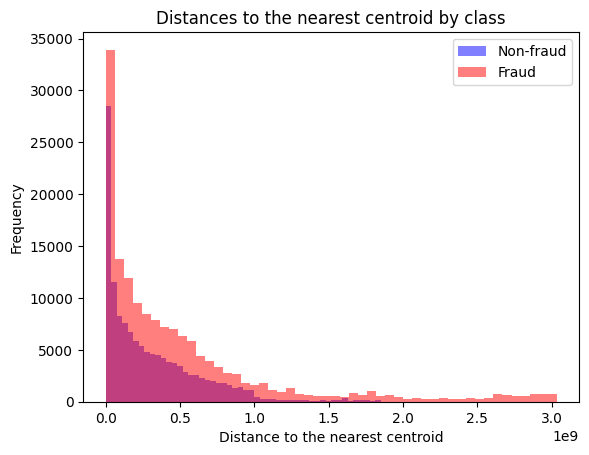

In [86]:
fraud_operations = data_with_distances.filter(data_with_distances['prediction'] == 1)
fraud_operations.describe().show()
non_fraud_operations = data_with_distances.filter(data_with_distances['prediction'] == 0)
non_fraud_operations.describe().show()

# Plot the distances to the nearest centroid
fraud_distances = fraud_operations.select("distance_to_nearest_centroid").toPandas()
non_fraud_distances = non_fraud_operations.select("distance_to_nearest_centroid").toPandas()
# Plot the distances to the nearest centroid and use different colors for fraud and non-fraud and diff color for incorrect fraud detection
plt.hist(non_fraud_distances, bins=50, color='blue', alpha=0.5, label='Non-fraud')
plt.hist(fraud_distances, bins=50, color='red', alpha=0.5, label='Fraud')
plt.legend()
plt.xlabel("Distance to the nearest centroid")
plt.ylabel("Frequency")
plt.title("Distances to the nearest centroid by class")
plt.show()


Використання IsoForest для пошуку аномалій.

/home/andrew/Documents/repos/big_data/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/andrew/Documents/repos/big_data/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/andrew/Documents/repos/big_data/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/andrew/Documents/repos/big_data/.venv/lib/python3.12/site-packages/sklearn/model_selection/

isolation_forest_anomaly
0    281958
1      2849
Name: count, dtype: int64
Silhouette Score: 0.7106791840010575


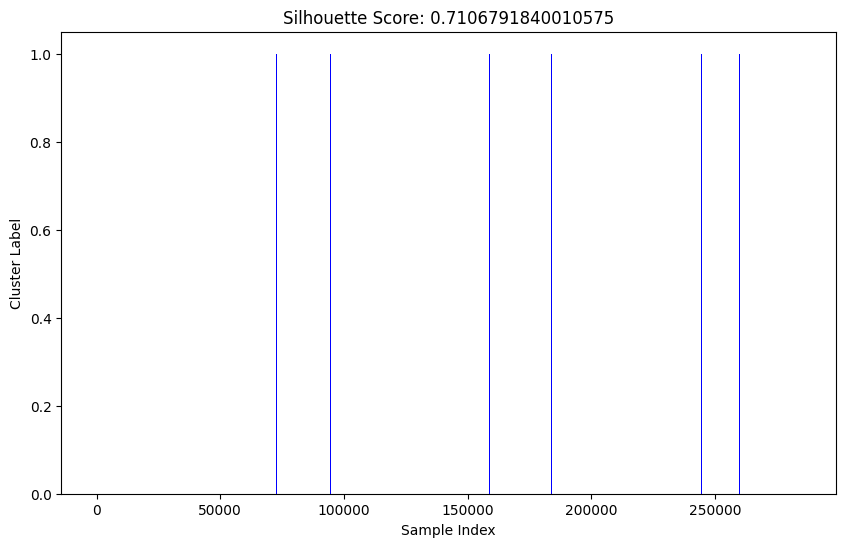

In [21]:
features =  features = [col for col in data.columns if col not in ['Class', 'Time']]
labels = ['Class']

assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled_data = assembler.transform(data)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(assembled_data)
normalized_features = scaler_model.transform(assembled_data)

# Convert to pandas dataframe for Isolation Forest
normalized_features_pd = normalized_features.select("scaled_features").toPandas()
normalized_features_np = np.array(normalized_features_pd["scaled_features"].tolist())

# Using the Isolation Forest algorithm
iso_forest = IsolationForest(
    n_estimators=200,  # Number of base estimators in the ensemble
    max_samples='auto',  # Number of samples to draw from X to train each base estimator
    contamination=0.01,  # Proportion of outliers in the data set
    max_features=1.0,  # Number of features to draw from X to train each base estimator
    random_state=3345
)
balanced_df_pd = data.toPandas()
balanced_df_pd['isolation_forest_anomaly'] = iso_forest.fit_predict(normalized_features_np)

# Convert predictions to binary: 0 for inliers, 1 for outliers
balanced_df_pd['isolation_forest_anomaly'] = balanced_df_pd['isolation_forest_anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Evaluate the model
print(balanced_df_pd['isolation_forest_anomaly'].value_counts().sort_index())

result = balanced_df_pd['isolation_forest_anomaly'] == 1
#save the model



In [35]:
# describe the data
balanced_df_pd[["Amount", "V11", "V4", "V2"]].where(balanced_df_pd["isolation_forest_anomaly"] == 1).describe()

,Amount,V11,V4,V2
count,2849.000000,2849.000000,2849.000000,2849.000000
mean,948.650232,0.766566,1.586276,-2.620376
std,1613.803997,2.371457,3.285752,9.881965
min,0.000000,-4.797473,-5.266509,-72.715728
25%,7.700000,-0.807358,-0.854861,-8.669289
50%,107.850000,0.442700,1.132660,-0.811359
75%,1650.000000,1.808420,3.509292,5.042032
max,25691.160000,12.018913,16.875344,22.057729


In [ ]:
data_to_explain = balanced_df_pd[balanced_df_pd['isolation_forest_anomaly'] == 1]

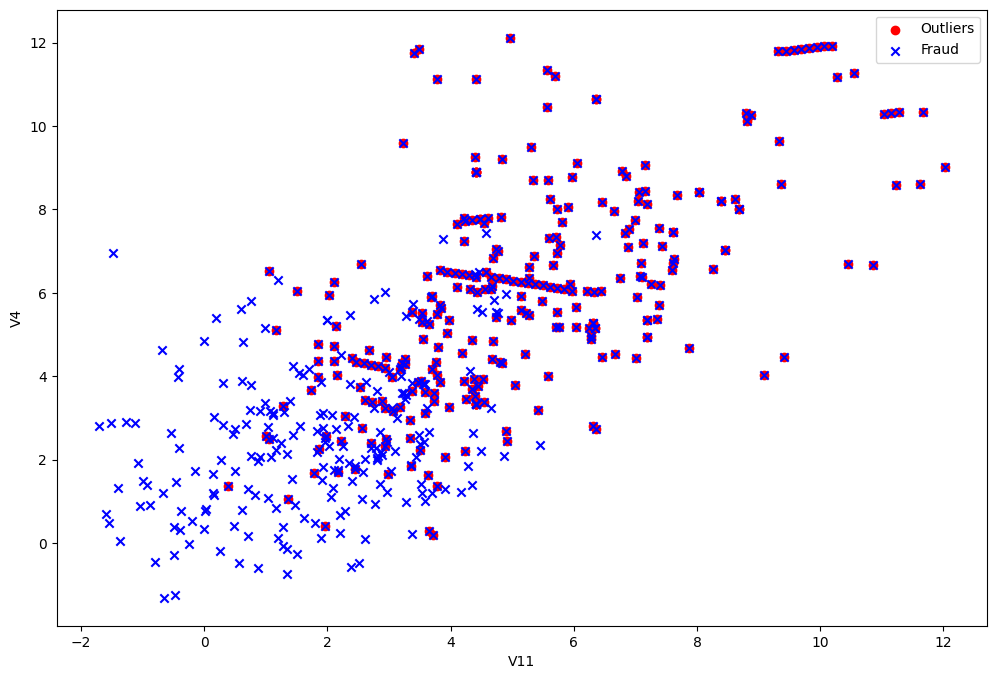

In [18]:
# Visualize the output of IQR method and real fraud operations

# Convert to Pandas DataFrame
outliers_pd = balanced_df_pd[(balanced_df_pd['isolation_forest_anomaly'] == 1) & (balanced_df_pd['Class'] == 1)]

fraud_pd = data.select("Amount", "V11", "V4", "V2").where(data.Class == 1).toPandas()

plt.figure(figsize=(12, 8))
# Plot the data with different markers
plt.scatter(outliers_pd['V11'], outliers_pd['V4'], color='red', label='Outliers', marker='o')
plt.scatter(fraud_pd['V11'], fraud_pd['V4'], color='blue', label='Fraud', marker='x')
plt.xlabel('V11')
plt.ylabel('V4')
plt.legend()
plt.show()

Використання DBSCAN для кластеризації даних. І пошуку аномалій.

In [9]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(normalized_features_np)

# Convert predictions to binary: 0 for inliers, 1 for outliers
balanced_df_pd['dbscan_anomaly'] = dbscan_labels
balanced_df_pd['dbscan_anomaly'] = balanced_df_pd['dbscan_anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Evaluate the model
print(balanced_df_pd['dbscan_anomaly'].value_counts().sort_index())

dbscan_anomaly
0     61791
1    223016
Name: count, dtype: int64
